TRABALHO DISCIPLINA INTELIGÊNCIA ARTIFICIAL APLICADA À CIÊNCIA ANIMAL - CLASSIFICAÇÃO DE RAÇAS BOVINAS EM SUBESPÉCIES

Imports de pacotes do Python

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Caminhos principais
base_path_zebuinos = '/content/drive/MyDrive/IA_ciencia_animal/TrabalhoIA/'
source_dir = os.path.join(base_path_zebuinos, 'Cattle/Zebuinos')
target_base_dir = os.path.join(base_path_zebuinos, 'Images/Zebuinos')

# Proporções para train, validation e test
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Diretórios de destino
train_dir = os.path.join(target_base_dir, 'train')
validation_dir = os.path.join(target_base_dir, 'validation')
test_dir = os.path.join(target_base_dir, 'test')

# Criar diretórios de destino, se não existirem
for directory in [train_dir, validation_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

# Listar todas as imagens no diretório de origem
images = [img for img in os.listdir(source_dir) if img.lower().endswith(('png', 'jpg', 'jpeg'))]

# Garantir que há imagens suficientes
if len(images) < 3:
    raise ValueError("O diretório de origem não contém imagens suficientes para dividir.")

# Divisão em treino, validação e teste
train_files, temp_files = train_test_split(images, train_size=train_ratio, random_state=42)
validation_files, test_files = train_test_split(temp_files, test_size=test_ratio / (validation_ratio + test_ratio), random_state=42)

# Função para mover arquivos para o diretório apropriado
def move_files(file_list, destination_dir):
    for file_name in file_list:
        source_path = os.path.join(source_dir, file_name)
        target_path = os.path.join(destination_dir, file_name)
        shutil.move(source_path, target_path)
        print(f"Arquivo '{file_name}' movido para '{destination_dir}'")

# Mover arquivos para os respectivos diretórios
move_files(train_files, train_dir)
move_files(validation_files, validation_dir)
move_files(test_files, test_dir)

print("Particionamento concluído.")

print("Treino:", len(train_files))
print("Validação:", len(validation_files))
print("Teste:", len(test_files))

Arquivo 'Gir_270.jpg' movido para '/content/drive/MyDrive/IA_ciencia_animal/TrabalhoIA/Images/Zebuinos/train'
Arquivo 'Gir_130.jpg' movido para '/content/drive/MyDrive/IA_ciencia_animal/TrabalhoIA/Images/Zebuinos/train'
Arquivo 'Gir_86.jpg' movido para '/content/drive/MyDrive/IA_ciencia_animal/TrabalhoIA/Images/Zebuinos/train'
Arquivo 'Gir_157.jpg' movido para '/content/drive/MyDrive/IA_ciencia_animal/TrabalhoIA/Images/Zebuinos/train'
Arquivo 'Gir_24.png' movido para '/content/drive/MyDrive/IA_ciencia_animal/TrabalhoIA/Images/Zebuinos/train'
Arquivo 'Gir_12.jPG' movido para '/content/drive/MyDrive/IA_ciencia_animal/TrabalhoIA/Images/Zebuinos/train'
Arquivo 'Gir_272.jpg' movido para '/content/drive/MyDrive/IA_ciencia_animal/TrabalhoIA/Images/Zebuinos/train'
Arquivo 'Gir_188.jpg' movido para '/content/drive/MyDrive/IA_ciencia_animal/TrabalhoIA/Images/Zebuinos/train'
Arquivo 'Gir_356.png' movido para '/content/drive/MyDrive/IA_ciencia_animal/TrabalhoIA/Images/Zebuinos/train'
Arquivo 'Gir_

In [3]:
import sys
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os


# NO CASO ESTÁ IMPORTANDO A CNN VGG16. CONSULTA NA INTERNET tensorflow.keras.applications
# POIS HÁ VARIAS OUTRAS CNNS QUE VC PODE TESTAR.
from tensorflow.keras.applications import VGG16


Monta o Google Drive

In [4]:
# define cnn model using VGG16
def define_model(nclasses, input_shape):

    # PARA TESTAR OUTRAS CNNS, ALÉM DA ALTERAÇÃO DA IMPORTAÇÃO DESSA ACIMA,
    # VC VAI TROCAR VGG16 PELO NOME DA CNN IMPORTADA

    # Load the VGG16 model, excluding the top (fully connected) layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model
    model = Sequential()
    # Add the VGG16 base model
    model.add(base_model)
    # Flatten the output from the base model
    model.add(Flatten())
    # Add new fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    # Output layer with num_classes units and softmax activation
    model.add(Dense(2, activation='softmax'))

    # Compile the model with categorical crossentropy for multi-class classification
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'F1Score'])

    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')
    plt.close()

# Funcao principal
def funcao_principal(num_classes, base_path, input_shape, model_name, epochs):
    # chama a função que define o modelo da rede
    model = define_model(num_classes, input_shape)

    # cria o gerador de dados de treino fazendo a normalização dos valores de pixels na escala real [0,1] e tirando 30% das amostras para validacao
    datagen_train = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.15)

    # cria o gerador de dados de teste fazendo a normalização dos valores de pixels na escala real [0,1]
    datagen_test = ImageDataGenerator(rescale=1.0/255.0)

    # prepara os iteradores
    batch_size = 32

    # SE VOCÊ TIVER COM CONTA COLAB PRO, O CERTO É ZIPAR, BAIXAR E DESCOMPACTAR OS ARQUIVOS PARA A MAQUINA.
    # PELO Drive O ACESSO É LENTO
    train_it = datagen_train.flow_from_directory(os.path.join(base_path, 'train'),
        class_mode='categorical', batch_size=batch_size, target_size=(200, 200))

    validation_it = datagen_train.flow_from_directory(os.path.join(base_path, 'validation'),
        class_mode='categorical', batch_size=batch_size, target_size=(200, 200))

    test_it = datagen_test.flow_from_directory(os.path.join(base_path,'test'),
        class_mode='categorical', target_size=(200, 200))


    # Define callback/heurística para salvar o melhor modelo com base em val_loss
    checkpoint = ModelCheckpoint(filepath=os.path.join(base_path, model_name), monitor='val_loss', save_best_only=True, mode='min', verbose=1)

    # Define callback/heurística de redução de taxa de aprendizado sob plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5, verbose=1)

    # Define callback/heurística para parar o treinamento mais cedo em caso de estagnação. Evita overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # fit model
    history = model.fit(train_it, validation_data=validation_it,
        validation_steps=validation_it.samples//batch_size, epochs=epochs,
                        callbacks=[checkpoint, reduce_lr, early_stopping],verbose=2)

Chama a função principal

In [5]:
# Aciona o programa
input_shape = (200, 200, 3)
epochs = 30


base_path  = '/content/drive/MyDrive/IA_ciencia_animal/TrabalhoIA/Images'
model_name = 'vgg16_cattle.keras'

nclasses = 2

funcao_principal(nclasses, base_path, input_shape, model_name, epochs)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Found 1353 images belonging to 2 classes.
Found 294 images belonging to 2 classes.
Found 289 images belonging to 2 classes.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.33618, saving model to /content/drive/MyDrive/IA_ciencia_animal/TrabalhoIA/Images/vgg16_cattle.keras
43/43 - 933s - 22s/step - F1Score: 0.7534 - accuracy: 0.7554 - loss: 0.4997 - precision: 0.7554 - recall: 0.7554 - val_F1Score: 0.8734 - val_accuracy: 0.8750 - val_loss: 0.3362 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 0.33618 to 0.17717, saving model to /content/drive/MyDrive/IA_ciencia_animal/TrabalhoIA/Images/vgg16_cattle.keras


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


43/43 - 76s - 2s/step - F1Score: 0.9182 - accuracy: 0.9187 - loss: 0.2610 - precision: 0.9187 - recall: 0.9187 - val_F1Score: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.1772 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss did not improve from 0.17717
43/43 - 40s - 940ms/step - F1Score: 0.9399 - accuracy: 0.9401 - loss: 0.1836 - precision: 0.9401 - recall: 0.9401 - val_F1Score: 0.9061 - val_accuracy: 0.9062 - val_loss: 0.2389 - val_precision: 0.9062 - val_recall: 0.9062 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss did not improve from 0.17717
43/43 - 37s - 856ms/step - F1Score: 0.9695 - accuracy: 0.9697 - loss: 0.1272 - precision: 0.9697 - recall: 0.9697 - val_F1Score: 0.7778 - val_accuracy: 0.8333 - val_loss: 0.3763 - val_precision: 0.8333 - val_recall: 0.8333 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_loss did not improve from 0.17717

Epoch 5: ReduceLROnPlateau reducing learning rate to 1e-05.
43/43 - 25s 

Avalia o Modelo

Found 289 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 - 149s - 15s/step - F1Score: 0.9304 - accuracy: 0.9308 - loss: 0.2184 - precision: 0.9308 - recall: 0.9308
Perda: 0.218
Acurácia: 93.080%
Precisão: 93.080
Revocação: 93.080
10/10 - 4s - 444ms/step
[[124  12]
 [  8 145]]


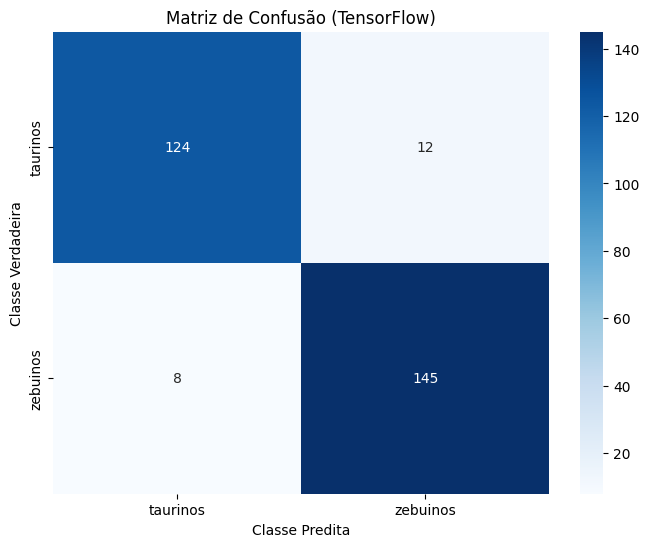

In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

base_path  = '/content/drive/MyDrive/IA_ciencia_animal/TrabalhoIA/Images'
model_name = 'vgg16_cattle.keras'


# cria o gerador de dados de teste fazendo a normalização dos valores de pixels na escala real [0,1]
datagen_test = keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)

test_it = datagen_test.flow_from_directory(
    os.path.join(base_path, 'test'),
    class_mode='categorical',
    target_size=(200, 200),
    shuffle=False  # Importante para manter as classes alinhadas
)

model = keras.models.load_model(os.path.join(base_path, model_name))

# Avalia o modelo
loss, accuracy, precision, recall, f1_score = model.evaluate(test_it, verbose=2)

print(f"Perda: {loss:.3f}")
print(f"Acurácia: {accuracy * 100.0:.3f}%")
print(f"Precisão: {precision * 100.0:.3f}")
print(f"Revocação: {recall * 100.0:.3f}")

# Obter as previsões do modelo
predictions = model.predict(test_it, verbose=2)

# A classe verdadeira de cada imagem
true_classes = test_it.classes

# Obter as previsões como uma classe, ou seja, o índice da classe com a maior probabilidade
predicted_classes = np.argmax(predictions, axis=1)

# Calcular a matriz de confusão com TensorFlow
conf_matrix_tf = tf.math.confusion_matrix(
    labels=true_classes,
    predictions=predicted_classes
).numpy()

print(conf_matrix_tf)

# Mostrar a matriz de confusão com o seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tf, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_it.class_indices.keys(),
            yticklabels=test_it.class_indices.keys())
plt.title('Matriz de Confusão (TensorFlow)')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.show()

In [8]:
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)


Loss: 0.218417689204216
Accuracy: 0.9307958483695984
Precision: 0.9307958483695984
Recall: 0.9307958483695984
F1-Score: tf.Tensor([0.9253731 0.9354838], shape=(2,), dtype=float32)


In [9]:
loss = loss[0] if isinstance(loss, (list, np.ndarray)) else loss
accuracy = accuracy[0] if isinstance(accuracy, (list, np.ndarray)) else accuracy
precision = precision[0] if isinstance(precision, (list, np.ndarray)) else precision
recall = recall[0] if isinstance(recall, (list, np.ndarray)) else recall
f1_score = f1_score[0] if isinstance(f1_score, (list, np.ndarray)) else f1_score

In [18]:
import tensorflow as tf

# Tensor retornado pelo modelo
f1_score_tensor = tf.constant([0.9253731, 0.9354838])
# Calcular a média (ou use outro método conforme necessário)
f1_score = tf.reduce_mean(f1_score_tensor).numpy()  # Convertendo para float
f1_score = f1_score_tensor[0].numpy()  # Primeiro valor

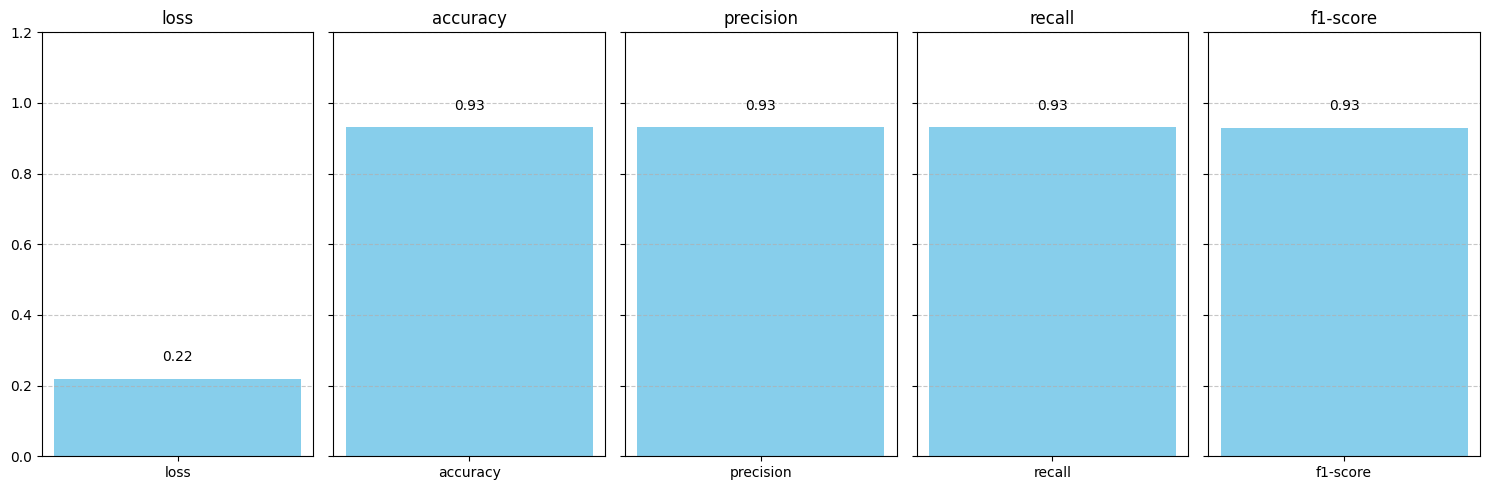

In [19]:
import matplotlib.pyplot as plt

# Resultados do modelo (exemplo de valores, substitua pelos obtidos no seu `model.evaluate`)
loss: 0.218417689204216
accuracy: 0.9307958483695984
precision: 0.9307958483695984
recall: 0.9307958483695984

# Substituir pelo valor consolidado
f1_score = tf.reduce_mean(tf.constant([0.9253731, 0.9354838])).numpy()

# Métricas e valores
metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1-score']
values = [loss, accuracy, precision, recall, f1_score]

# Configurar a figura com subplots
fig, axs = plt.subplots(1, len(metrics), figsize=(15, 5), sharey=True)

# Criar gráficos individuais para cada métrica
for i, ax in enumerate(axs):
    ax.bar(metrics[i], values[i], color='skyblue')
    ax.set_ylim(0, 1.2)  # Limitar eixo Y entre 0 e 1.2 (ajuste se necessário)
    ax.set_title(metrics[i])
    ax.text(0, values[i] + 0.05, f"{values[i]:.2f}", ha='center', fontsize=10)  # Exibir o valor na barra
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()


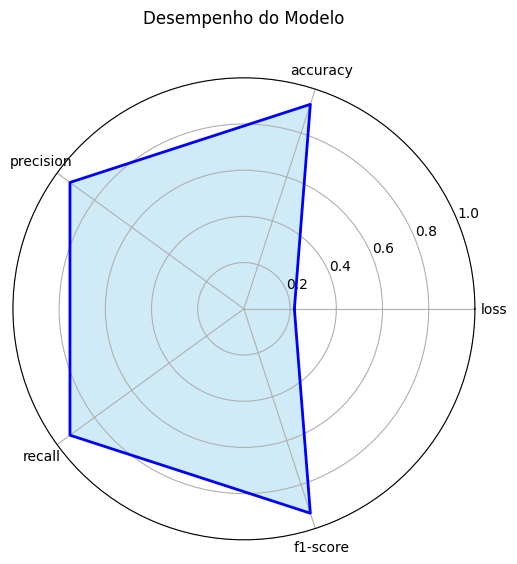

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Dados
metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1-score']

# Preparar para radar chart
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
values += values[:1]  # Fechar o gráfico
angles += angles[:1]

# Criar gráfico
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values, color='skyblue', alpha=0.4)
ax.plot(angles, values, color='blue', linewidth=2)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_title('Desempenho do Modelo', y=1.1)

plt.show()
